In [1]:
import numpy as np
import pandas as pd
import pydicom
import cv2
from scipy.ndimage import zoom
from sklearn import preprocessing
from glob import glob
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def extract_number_from_path(path):
    match = re.search(r'(\d+)\.dcm$', path)
    if match:
        return int(match.group(1))
    return 0

def get_data_for_3d_volumes(data, train_data_cat, path, number_idx):

    data_to_merge = data[["patient_id", "series_id"]]
    patient_category = train_data_cat[["patient_id", "any_injury"]]
    
    merged_df = data_to_merge.merge(patient_category, on='patient_id', how='left')
    
    shuffled_data = merged_df.sample(frac=1, random_state=42)
    shuffled_indexes = shuffled_data.index[:number_idx]
    selected_rows = shuffled_data.loc[shuffled_indexes]
    data_to_merge_processed = selected_rows.reset_index()
    
    total_paths = []
    patient_ids = []
    series_ids = []
    category = []
    
    for patient_id in range(len(data_to_merge_processed)):
    
        p_id = str(data_to_merge_processed["patient_id"][patient_id]) + "/" + str(data_to_merge_processed["series_id"][patient_id])
        str_imgs_path = path + p_id + '/'
        patient_img_paths = []

        for file in glob(str_imgs_path + '/*'):
            patient_img_paths.append(file)
        
        
        sorted_file_paths = sorted(patient_img_paths, key=extract_number_from_path)
        total_paths.append(sorted_file_paths)
        patient_ids.append(data_to_merge_processed["patient_id"][patient_id])
        series_ids.append(data_to_merge_processed["series_id"][patient_id])
        category.append(data_to_merge_processed["any_injury"][patient_id])
    
    final_data = pd.DataFrame(list(zip(patient_ids, series_ids, total_paths, category)),
               columns =["Patient_id","Series_id", "Patient_paths", "Patient_category"])
    
    return final_data

def window_converter(image, window_width=400, window_level=50):      
    img_min = window_level - window_width // 2
    img_max = window_level + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    #image = (image / image.max() * 255).astype(np.float64)
    return window_image

def transform_to_hu(medical_image, image):
    meta_image = pydicom.dcmread(medical_image)
    intercept = meta_image.RescaleIntercept
    slope = meta_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
        pixel_array = dcm.pixel_array
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype 
            pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift
        return pixel_array

def resize_img(img_paths, target_size=(128, 128)):
        volume_shape = (target_size[0], target_size[1], len(img_paths)) 
        volume = np.zeros(volume_shape, dtype=np.float64)
        for i, image_path in enumerate(img_paths):
            image = pydicom.read_file(image_path)
            image = standardize_pixel_array(image)
            hu_image = transform_to_hu(image_path, image)
            window_image = window_converter(hu_image)
            image = cv2.resize(window_image, target_size)
            volume[:,:,i] = image
        return volume
    
def change_depth_siz(patient_volume, target_depth=64):
    desired_depth = target_depth
    current_depth = patient_volume.shape[-1]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(patient_volume, (1, 1, depth_factor), mode='nearest')
    return img_new
    
def normalize_volume(resized_volume):
    original_shape = resized_volume.shape
    flattened_image = resized_volume.reshape((-1,))
    scaler = preprocessing.MinMaxScaler()
    normalized_flattened_image = scaler.fit_transform(flattened_image.reshape((-1, 1)))
    normalized_volume_image = normalized_flattened_image.reshape(original_shape)
    return normalized_volume_image

def generate_patient_processed_data(list_img_paths, list_labels, target_size=(128,128), target_depth=64):

    num_patients = len(list_img_paths)
    height = target_size[0]
    width = target_size[1]
    depth = target_depth

    volume_array = np.zeros((height, width, depth), dtype=np.float64)
    labels_array = np.array(list_labels, dtype=np.float64)

    print("Initializing data preprocessing with the following dimensions-> Volumes:{} Labels:{}".format(volume_array.shape, labels_array.shape))

    resized_images = resize_img(list_img_paths, target_size=target_size)
    siz_volume = change_depth_siz(resized_images)
    normalized_siz_volume = normalize_volume(siz_volume)

    volume_array = normalized_siz_volume

    return volume_array, labels_array

def string_to_list(string_repr):
    return eval(string_repr)

In [3]:
path="/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/"
path_meta_data = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv"
path_train_data = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv"

num_idx=100

meta_data = pd.read_csv(path_meta_data)
train_data = pd.read_csv(path_train_data)


cleaned_df = get_data_for_3d_volumes(meta_data, train_data, path=path, number_idx=num_idx)

In [4]:
cleaned_df

,Patient_id,Series_id,Patient_paths,Patient_category
0,25102,50875,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,1
1,31158,28163,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
2,51177,42398,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
3,56046,38794,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
4,56400,12546,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
...,...,...,...,...
95,35863,15797,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,1
96,10249,2346,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
97,26471,49728,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,0
98,38343,19637,[/kaggle/input/rsna-2023-abdominal-trauma-dete...,1


In [36]:
train_images = cleaned_df["Patient_paths"][99][:10]
train_images

['/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/1.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/2.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/3.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/4.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/5.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/6.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/7.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/8.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/9.dcm',
 '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/51736/60262/10.dcm']

In [6]:
def crop_center_cv2(image_path, target_size):
    """
    Crop the center region of an image using OpenCV and save it to the specified output path.

    Args:
        image_path (str): The path to the input image.
        target_size (tuple): A tuple (width, height) specifying the desired size of the cropped region.

    Returns:
        None
    """
    try:
        # Read the image using OpenCV
        image = pydicom.read_file(image_path)
        image = standardize_pixel_array(image)
        hu_image = transform_to_hu(image_path, image)
        img = window_converter(hu_image)
        #img = window_image.astype("uint8")

        # Get the size of the original image
        height, width = img.shape[:2]

        # Calculate the coordinates for cropping the center region
        left = (width - target_size[0]) // 2
        top = (height - target_size[1]) // 2
        right = (width + target_size[0]) // 2
        bottom = (height + target_size[1]) // 2

        # Crop the center region
        cropped_img = img[top:bottom, left:right]
        
        return cropped_img

    except Exception as e:
        print(f"Error: {e}")

In [7]:
cropped_image = crop_center_cv2(train_images[0], (384, 384))


image = pydicom.read_file(train_images[0])
image = standardize_pixel_array(image)
hu_image = transform_to_hu(train_images[0], image)
original_image = window_converter(hu_image)

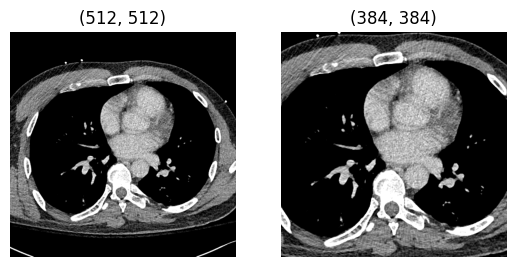

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(original_image, cmap='gray')
ax2.imshow(cropped_image, cmap='gray')
ax1.set_title(str(original_image.shape))
ax2.set_title(str(cropped_image.shape))
ax1.axis('off')
ax2.axis('off');

In [19]:

def crop_center_with_margin(image_path, margin_pixels):
    """
    Crop the center region of an image with a specified number of pixels above and below the middle.

    Args:
        image_path (str): The path to the input image.
        output_path (str): The path to save the cropped image.
        margin_pixels (int): The number of pixels above and below the middle to include in the crop.

    Returns:
        cropped_image
    """
    try:
        # Read the image using OpenCV
        image = pydicom.read_file(image_path)
        image = standardize_pixel_array(image)
        hu_image = transform_to_hu(image_path, image)
        img = window_converter(hu_image)

        # Get the size of the original image
        height, width = img.shape[:2]

        # Calculate the coordinates for cropping the center region with margin
        top = margin_pixels
        bottom = height - margin_pixels
        left = 0
        right = width

        # Crop the region with margin
        cropped_img = img[top:bottom, left:right]
        return cropped_img


    except Exception as e:
        print(f"Error: {e}")

In [39]:
margin_pixels = 50
idx= 9


cropped_image = crop_center_with_margin(train_images[idx], margin_pixels=margin_pixels)


image = pydicom.read_file(train_images[idx])
image = standardize_pixel_array(image)
hu_image = transform_to_hu(train_images[idx], image)
original_image = window_converter(hu_image)

In [34]:
cropped_image.shape

(352, 512)

In [42]:
def crop_center_with_margin(image, margin_pixels):
    
    try:

        # Get the size of the original image
        height, width = image.shape[:2]

        # Calculate the coordinates for cropping the center region with margin
        top = margin_pixels
        bottom = height - margin_pixels
        left = 0
        right = width

        # Crop the region with margin
        cropped_img = image[top:bottom, left:right]
        return cropped_img


    except Exception as e:
        print(f"Error: {e}")

In [44]:
original_img = crop_center_with_margin(original_image, margin_pixels=margin_pixels)

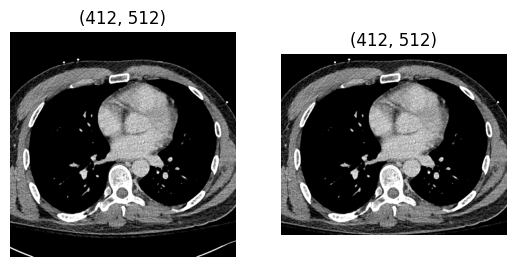

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(original_image, cmap='gray')
ax2.imshow(cropped_image, cmap='gray')
ax1.set_title(str(original_img.shape))
ax2.set_title(str(cropped_image.shape))
ax1.axis('off')
ax2.axis('off');

In [71]:
def extract_number_from_path(path):
    match = re.search(r'(\d+)\.dcm$', path)
    if match:
        return int(match.group(1))
    return 0

def get_data_for_3d_volumes(data, train_data_cat, path, number_idx):

    data_to_merge = data[["patient_id", "series_id"]]
    patient_category = train_data_cat[["patient_id", "any_injury"]]
    
    merged_df = data_to_merge.merge(patient_category, on='patient_id', how='left')
    
    shuffled_data = merged_df.sample(frac=1, random_state=42)
    shuffled_indexes = shuffled_data.index[:number_idx]
    selected_rows = shuffled_data.loc[shuffled_indexes]
    data_to_merge_processed = selected_rows.reset_index()
    
    total_paths = []
    patient_ids = []
    series_ids = []
    category = []
    
    for patient_id in range(len(data_to_merge_processed)):
    
        p_id = str(data_to_merge_processed["patient_id"][patient_id]) + "/" + str(data_to_merge_processed["series_id"][patient_id])
        str_imgs_path = path + p_id + '/'
        patient_img_paths = []

        for file in glob(str_imgs_path + '/*'):
            patient_img_paths.append(file)
        
        
        sorted_file_paths = sorted(patient_img_paths, key=extract_number_from_path)
        total_paths.append(sorted_file_paths)
        patient_ids.append(data_to_merge_processed["patient_id"][patient_id])
        series_ids.append(data_to_merge_processed["series_id"][patient_id])
        category.append(data_to_merge_processed["any_injury"][patient_id])
    
    final_data = pd.DataFrame(list(zip(patient_ids, series_ids, total_paths, category)),
               columns =["Patient_id","Series_id", "Patient_paths", "Patient_category"])
    
    return final_data

def crop_center_with_margin(image, margin_pixels):
    
    try:

        # Get the size of the original image
        height, width = image.shape[:2]

        # Calculate the coordinates for cropping the center region with margin
        top = margin_pixels
        bottom = height - (margin_pixels + 30)
        left = 0
        right = width

        # Crop the region with margin
        cropped_img = image[top:bottom, left:right]
        return cropped_img


    except Exception as e:
        print(f"Error: {e}")

def window_converter(image, window_width=400, window_level=50):      
    img_min = window_level - window_width // 2
    img_max = window_level + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    #image = (image / image.max() * 255).astype(np.float64)
    return window_image

def transform_to_hu(medical_image, image):
    meta_image = pydicom.dcmread(medical_image)
    intercept = meta_image.RescaleIntercept
    slope = meta_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
        pixel_array = dcm.pixel_array
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype 
            pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift
        return pixel_array

def resize_img(img_paths, target_size=(128, 128)):
        volume_shape = (target_size[0], target_size[1], len(img_paths)) 
        volume = np.zeros(volume_shape, dtype=np.float64)
        for i, image_path in enumerate(img_paths):
            image = pydicom.read_file(image_path)
            image = standardize_pixel_array(image)
            hu_image = transform_to_hu(image_path, image)
            window_image = window_converter(hu_image)
            window_image_roi = crop_center_with_margin(window_image, margin_pixels=60)
            image = cv2.resize(window_image_roi, target_size)
            volume[:,:,i] = image
        return volume
    
def change_depth_siz(patient_volume, target_depth=64):
    desired_depth = target_depth
    current_depth = patient_volume.shape[-1]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(patient_volume, (1, 1, depth_factor), mode='nearest')
    return img_new
    
def normalize_volume(resized_volume):
    original_shape = resized_volume.shape
    flattened_image = resized_volume.reshape((-1,))
    scaler = preprocessing.MinMaxScaler()
    normalized_flattened_image = scaler.fit_transform(flattened_image.reshape((-1, 1)))
    normalized_volume_image = normalized_flattened_image.reshape(original_shape)
    return normalized_volume_image

def generate_patient_processed_data(list_img_paths, list_labels, target_size=(128,128), target_depth=64):

    num_patients = len(list_img_paths)
    height = target_size[0]
    width = target_size[1]
    depth = target_depth

    volume_array = np.zeros((height, width, depth), dtype=np.float64)
    labels_array = np.array(list_labels, dtype=np.float64)

    print("Initializing data preprocessing with the following dimensions-> Volumes:{} Labels:{}".format(volume_array.shape, labels_array.shape))

    resized_images = resize_img(list_img_paths, target_size=target_size)
    siz_volume = change_depth_siz(resized_images)
    normalized_siz_volume = normalize_volume(siz_volume)

    volume_array = normalized_siz_volume

    return volume_array, labels_array

def string_to_list(string_repr):
    return eval(string_repr)

In [72]:
for i in range(len(cleaned_df[:2])):
    patient_data_volumes, _ = generate_patient_processed_data(cleaned_df["Patient_paths"][i],cleaned_df["Patient_category"][i], target_size=(128,128),target_depth=64)

    with open(f'/kaggle/working/{str(cleaned_df["Patient_id"][i])}_{str(cleaned_df["Series_id"][i])}.npy', 'wb') as f:
        np.save(f, patient_data_volumes)

Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()
Initializing data preprocessing with the following dimensions-> Volumes:(128, 128, 64) Labels:()


In [75]:
with open(f'/kaggle/working/25102_50875.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)

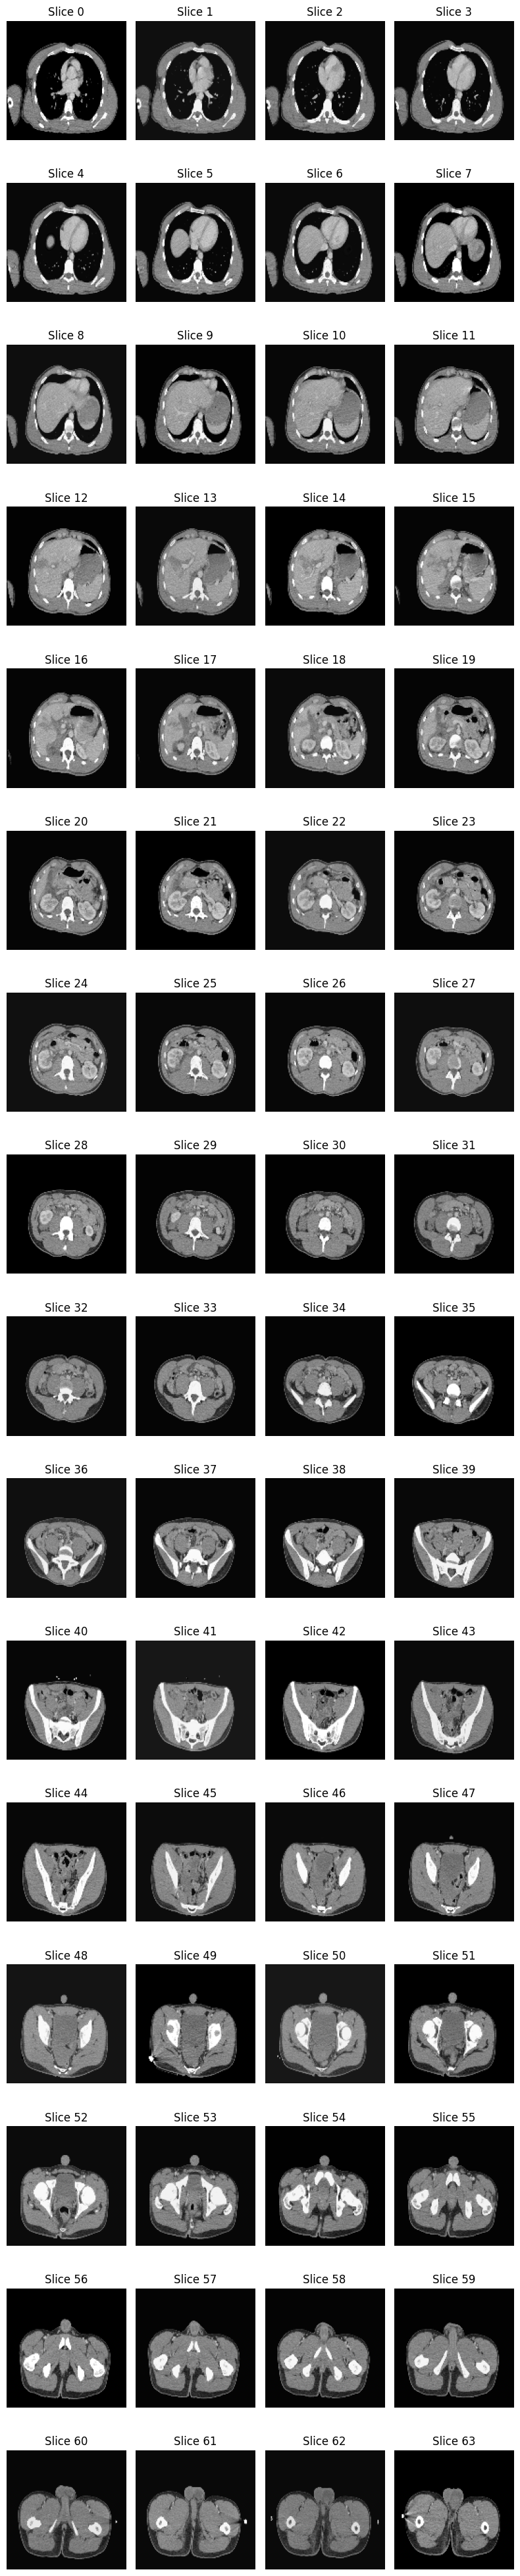

In [76]:
rows = 16  # Number of rows in the subplot grid
cols = 4  # Number of columns in the subplot grid
depth = 64

fig, axes = plt.subplots(rows, cols, figsize=(8, 44))
#fig.suptitle(f'3D Volume Slices, patient_series -> 201_49066')

for d in range(depth):
    row = d // cols
    col = d % cols
    
    ax = axes[row, col]
    ax.imshow(X[:,:,d], cmap='gray')  # You can change the colormap if needed
    ax.set_title(f"Slice {d}")
    ax.axis('off')  # Turn off axis for cleaner visualization

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the position of the suptitle

# Show the plot
plt.show()